# Lab | Generative Adversarial Network (GAN) on CIFAR-10 Dataset
### Generate Fun Colorful Images: Animals, Cars, and More!

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, datasets
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Import regularizers from tensorflow.keras
###
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

from tqdm import tqdm

In [2]:
# Load and preprocess CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Normalize pixel values to [-1, 1] (better for GAN training)
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_test = (x_test.astype('float32') - 127.5) / 127.5

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Pixel value range: [{x_train.min():.2f}, {x_train.max():.2f}]")

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Set parameters
latent_dim = 100

Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Pixel value range: [-1.00, 1.00]


In [3]:
# Build the Generator Model
### YOUR CODE HERE
def make_generator_model():
    model = tf.keras.Sequential()
    
    # Dense layer that will be reshaped
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Reshape to start the convolutional stack
    model.add(layers.Reshape((8, 8, 256)))
    
    # Upsample to 16x16
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Upsample to 32x32 (CIFAR-10 size)
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

generator = make_generator_model()

C:\Users\Amin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Build the Discriminator Model
### YOUR CODE HERE
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

discriminator = make_discriminator_model()


C:\Users\Amin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Define loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    ### YOUR CODE HERE
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    ### YOUR CODE HERE
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [6]:
# Define optimizers
### YOUR CODE HERE
generator_optimizer = Adam(1e-4) # Your-Code-Here
discriminator_optimizer = Adam(1e-4) # Your-Code-Here
###

In [7]:
# Training step function
@tf.function
def train_step(images):
    noise = tf.random.normal([tf.shape(images)[0], latent_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss


In [10]:
# Training parameters
EPOCHS = 50
BATCH_SIZE = 128
num_examples_to_generate = 16

# Create dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(50000).batch(BATCH_SIZE)


# Training loop
gen_losses = []
disc_losses = []

# Training loop with tqdm progress bars
for epoch in range(EPOCHS):
    epoch_start = time.time()
    epoch_gen_loss = 0
    epoch_disc_loss = 0
    num_batches = 0
    
    # Create progress bar for batches
    pbar = tqdm(enumerate(train_dataset), 
                total=len(x_train) // BATCH_SIZE,
                desc=f'Epoch {epoch+1}/{EPOCHS}')
    
    for batch_idx, image_batch in pbar:
        gen_loss, disc_loss = train_step(image_batch)
        epoch_gen_loss += gen_loss
        epoch_disc_loss += disc_loss
        num_batches += 1
        
        # Update progress bar with current losses
        pbar.set_postfix({
            'Gen Loss': f'{gen_loss:.4f}',
            'Disc Loss': f'{disc_loss:.4f}'
        })

    # Average losses for the epoch
    avg_gen_loss = epoch_gen_loss / num_batches
    avg_disc_loss = epoch_disc_loss / num_batches
        
    gen_losses.append(avg_gen_loss)
    disc_losses.append(avg_disc_loss)

    epoch_time = time.time() - epoch_start

    print(f"Epoch {epoch+1}/{EPOCHS} completed - "
        f"Avg Gen Loss: {avg_gen_loss:.4f}, "
        f"Avg Disc Loss: {avg_disc_loss:.4f}, "
        f"Time: {epoch_time:.2f}s")

Epoch 1/50: 391it [02:37,  2.48it/s, Gen Loss=3.9608, Disc Loss=0.2073]                         


Epoch 1/50 completed - Avg Gen Loss: 3.4522, Avg Disc Loss: 0.3311, Time: 157.43s


Epoch 2/50: 391it [03:19,  1.96it/s, Gen Loss=3.2574, Disc Loss=0.4903]                         


Epoch 2/50 completed - Avg Gen Loss: 3.7784, Avg Disc Loss: 0.2777, Time: 199.99s


Epoch 3/50: 391it [03:03,  2.13it/s, Gen Loss=2.0437, Disc Loss=0.6370]                         


Epoch 3/50 completed - Avg Gen Loss: 2.9072, Avg Disc Loss: 0.4690, Time: 183.92s


Epoch 4/50: 391it [03:39,  1.78it/s, Gen Loss=1.3971, Disc Loss=1.0284]                         


Epoch 4/50 completed - Avg Gen Loss: 1.9265, Avg Disc Loss: 0.7894, Time: 219.18s


Epoch 5/50: 391it [03:51,  1.69it/s, Gen Loss=1.2751, Disc Loss=1.2638]                         


Epoch 5/50 completed - Avg Gen Loss: 1.3158, Avg Disc Loss: 0.9780, Time: 231.80s


Epoch 6/50: 391it [03:45,  1.74it/s, Gen Loss=1.1329, Disc Loss=1.5999]                         


Epoch 6/50 completed - Avg Gen Loss: 1.5573, Avg Disc Loss: 0.9381, Time: 225.21s


Epoch 7/50: 391it [03:10,  2.05it/s, Gen Loss=0.9417, Disc Loss=1.1483]                         


Epoch 7/50 completed - Avg Gen Loss: 0.9543, Avg Disc Loss: 1.3043, Time: 190.94s


Epoch 8/50: 391it [03:17,  1.98it/s, Gen Loss=0.8009, Disc Loss=1.5010]                         


Epoch 8/50 completed - Avg Gen Loss: 0.8837, Avg Disc Loss: 1.2778, Time: 197.71s


Epoch 9/50: 391it [03:09,  2.06it/s, Gen Loss=1.0399, Disc Loss=1.1917]                         


Epoch 9/50 completed - Avg Gen Loss: 0.9103, Avg Disc Loss: 1.2559, Time: 189.39s


Epoch 10/50: 391it [02:01,  3.21it/s, Gen Loss=1.0297, Disc Loss=1.3137]                         


Epoch 10/50 completed - Avg Gen Loss: 0.9059, Avg Disc Loss: 1.2899, Time: 121.95s


Epoch 11/50: 391it [01:50,  3.52it/s, Gen Loss=0.8120, Disc Loss=1.2789]                         


Epoch 11/50 completed - Avg Gen Loss: 0.8529, Avg Disc Loss: 1.3297, Time: 111.00s


Epoch 12/50: 391it [01:51,  3.52it/s, Gen Loss=0.6241, Disc Loss=1.5560]                         


Epoch 12/50 completed - Avg Gen Loss: 0.7569, Avg Disc Loss: 1.3625, Time: 111.24s


Epoch 13/50: 391it [01:51,  3.50it/s, Gen Loss=0.7169, Disc Loss=1.1936]                         


Epoch 13/50 completed - Avg Gen Loss: 0.8335, Avg Disc Loss: 1.3431, Time: 111.69s


Epoch 14/50: 391it [01:52,  3.48it/s, Gen Loss=0.8527, Disc Loss=1.3008]                         


Epoch 14/50 completed - Avg Gen Loss: 0.7416, Avg Disc Loss: 1.3875, Time: 112.39s


Epoch 15/50: 391it [01:51,  3.51it/s, Gen Loss=0.8221, Disc Loss=1.2098]                         


Epoch 15/50 completed - Avg Gen Loss: 0.7785, Avg Disc Loss: 1.3570, Time: 111.38s


Epoch 16/50: 391it [01:51,  3.52it/s, Gen Loss=1.1163, Disc Loss=1.1266]                         


Epoch 16/50 completed - Avg Gen Loss: 0.9100, Avg Disc Loss: 1.2563, Time: 111.23s


Epoch 17/50: 391it [01:51,  3.51it/s, Gen Loss=0.8813, Disc Loss=1.0786]                         


Epoch 17/50 completed - Avg Gen Loss: 0.9246, Avg Disc Loss: 1.2748, Time: 111.34s


Epoch 18/50: 391it [01:51,  3.50it/s, Gen Loss=0.7010, Disc Loss=1.7064]                         


Epoch 18/50 completed - Avg Gen Loss: 0.8145, Avg Disc Loss: 1.3474, Time: 111.63s


Epoch 19/50: 391it [01:51,  3.49it/s, Gen Loss=0.6999, Disc Loss=1.6263]                         


Epoch 19/50 completed - Avg Gen Loss: 0.8516, Avg Disc Loss: 1.3043, Time: 111.96s


Epoch 20/50: 391it [01:51,  3.50it/s, Gen Loss=1.1150, Disc Loss=0.8928]                         


Epoch 20/50 completed - Avg Gen Loss: 0.8598, Avg Disc Loss: 1.3198, Time: 111.81s


Epoch 21/50: 391it [01:51,  3.50it/s, Gen Loss=0.9343, Disc Loss=1.1009]                         


Epoch 21/50 completed - Avg Gen Loss: 0.9402, Avg Disc Loss: 1.2536, Time: 111.86s


Epoch 22/50: 391it [01:52,  3.48it/s, Gen Loss=0.9680, Disc Loss=0.9778]                         


Epoch 22/50 completed - Avg Gen Loss: 0.8851, Avg Disc Loss: 1.2719, Time: 112.49s


Epoch 23/50: 391it [01:51,  3.49it/s, Gen Loss=0.9116, Disc Loss=1.3775]                         


Epoch 23/50 completed - Avg Gen Loss: 1.0025, Avg Disc Loss: 1.2125, Time: 111.88s


Epoch 24/50: 391it [01:52,  3.49it/s, Gen Loss=0.8351, Disc Loss=1.3001]                         


Epoch 24/50 completed - Avg Gen Loss: 0.9218, Avg Disc Loss: 1.2427, Time: 112.04s


Epoch 25/50: 391it [01:52,  3.48it/s, Gen Loss=0.9795, Disc Loss=1.0511]                         


Epoch 25/50 completed - Avg Gen Loss: 0.9506, Avg Disc Loss: 1.2436, Time: 112.44s


Epoch 26/50: 391it [01:52,  3.48it/s, Gen Loss=0.9016, Disc Loss=1.1915]                         


Epoch 26/50 completed - Avg Gen Loss: 1.0116, Avg Disc Loss: 1.1497, Time: 112.50s


Epoch 27/50: 391it [01:51,  3.49it/s, Gen Loss=0.8958, Disc Loss=1.2338]                         


Epoch 27/50 completed - Avg Gen Loss: 1.0006, Avg Disc Loss: 1.2092, Time: 111.96s


Epoch 28/50: 391it [01:54,  3.41it/s, Gen Loss=0.7633, Disc Loss=1.5106]                         


Epoch 28/50 completed - Avg Gen Loss: 0.9643, Avg Disc Loss: 1.2448, Time: 114.66s


Epoch 29/50: 391it [01:50,  3.55it/s, Gen Loss=0.9579, Disc Loss=1.1865]                         


Epoch 29/50 completed - Avg Gen Loss: 1.0187, Avg Disc Loss: 1.1944, Time: 110.13s


Epoch 30/50: 391it [01:50,  3.54it/s, Gen Loss=0.8998, Disc Loss=1.2900]                         


Epoch 30/50 completed - Avg Gen Loss: 0.9426, Avg Disc Loss: 1.2430, Time: 110.33s


Epoch 31/50: 391it [01:50,  3.54it/s, Gen Loss=0.8118, Disc Loss=1.3209]                         


Epoch 31/50 completed - Avg Gen Loss: 0.9333, Avg Disc Loss: 1.2670, Time: 110.46s


Epoch 32/50: 391it [01:50,  3.54it/s, Gen Loss=1.1013, Disc Loss=0.9568]                         


Epoch 32/50 completed - Avg Gen Loss: 0.9174, Avg Disc Loss: 1.2987, Time: 110.43s


Epoch 33/50: 391it [01:50,  3.54it/s, Gen Loss=0.8788, Disc Loss=1.2567]                         


Epoch 33/50 completed - Avg Gen Loss: 0.8908, Avg Disc Loss: 1.3093, Time: 110.36s


Epoch 34/50: 391it [01:50,  3.53it/s, Gen Loss=0.9977, Disc Loss=1.0585]                         


Epoch 34/50 completed - Avg Gen Loss: 0.8998, Avg Disc Loss: 1.2534, Time: 110.88s


Epoch 35/50: 391it [01:51,  3.51it/s, Gen Loss=1.0028, Disc Loss=1.2637]                         


Epoch 35/50 completed - Avg Gen Loss: 0.9067, Avg Disc Loss: 1.2809, Time: 111.52s


Epoch 36/50: 391it [01:50,  3.54it/s, Gen Loss=0.9834, Disc Loss=1.1476]                         


Epoch 36/50 completed - Avg Gen Loss: 0.9208, Avg Disc Loss: 1.2784, Time: 110.39s


Epoch 37/50: 391it [01:50,  3.55it/s, Gen Loss=1.1552, Disc Loss=0.9661]                         


Epoch 37/50 completed - Avg Gen Loss: 0.9160, Avg Disc Loss: 1.2908, Time: 110.20s


Epoch 38/50: 391it [01:51,  3.49it/s, Gen Loss=0.8061, Disc Loss=1.3780]                         


Epoch 38/50 completed - Avg Gen Loss: 0.8959, Avg Disc Loss: 1.3047, Time: 111.90s


Epoch 39/50: 391it [01:49,  3.56it/s, Gen Loss=1.1399, Disc Loss=1.0306]                         


Epoch 39/50 completed - Avg Gen Loss: 0.8806, Avg Disc Loss: 1.2842, Time: 109.80s


Epoch 40/50: 391it [01:50,  3.53it/s, Gen Loss=1.0423, Disc Loss=1.1867]                         


Epoch 40/50 completed - Avg Gen Loss: 0.9247, Avg Disc Loss: 1.2698, Time: 110.81s


Epoch 41/50: 391it [01:51,  3.52it/s, Gen Loss=0.9300, Disc Loss=1.2862]                         


Epoch 41/50 completed - Avg Gen Loss: 0.8747, Avg Disc Loss: 1.3010, Time: 111.18s


Epoch 42/50: 391it [01:50,  3.53it/s, Gen Loss=0.8455, Disc Loss=1.4681]                         


Epoch 42/50 completed - Avg Gen Loss: 0.9250, Avg Disc Loss: 1.3036, Time: 110.65s


Epoch 43/50: 391it [01:50,  3.55it/s, Gen Loss=0.9009, Disc Loss=1.1429]                         


Epoch 43/50 completed - Avg Gen Loss: 0.9076, Avg Disc Loss: 1.2988, Time: 110.03s


Epoch 44/50: 391it [01:54,  3.41it/s, Gen Loss=0.9688, Disc Loss=1.2095]                         


Epoch 44/50 completed - Avg Gen Loss: 0.8641, Avg Disc Loss: 1.3106, Time: 114.77s


Epoch 45/50: 391it [02:16,  2.86it/s, Gen Loss=0.7673, Disc Loss=1.3008]                         


Epoch 45/50 completed - Avg Gen Loss: 0.8537, Avg Disc Loss: 1.3069, Time: 136.86s


Epoch 46/50: 391it [02:43,  2.40it/s, Gen Loss=0.9023, Disc Loss=1.3425]                         


Epoch 46/50 completed - Avg Gen Loss: 0.8862, Avg Disc Loss: 1.2988, Time: 163.05s


Epoch 47/50: 391it [02:37,  2.48it/s, Gen Loss=0.7343, Disc Loss=1.4614]                         


Epoch 47/50 completed - Avg Gen Loss: 0.8636, Avg Disc Loss: 1.3004, Time: 157.45s


Epoch 48/50: 391it [02:01,  3.21it/s, Gen Loss=0.9096, Disc Loss=1.3093]                         


Epoch 48/50 completed - Avg Gen Loss: 0.8894, Avg Disc Loss: 1.2881, Time: 121.71s


Epoch 49/50: 391it [02:45,  2.36it/s, Gen Loss=0.9301, Disc Loss=1.3511]                         


Epoch 49/50 completed - Avg Gen Loss: 0.8843, Avg Disc Loss: 1.2916, Time: 165.66s


Epoch 50/50: 391it [02:25,  2.69it/s, Gen Loss=1.0875, Disc Loss=1.2114]                         

Epoch 50/50 completed - Avg Gen Loss: 0.8992, Avg Disc Loss: 1.3020, Time: 145.37s


## Exercise 1: Plot Training Losses

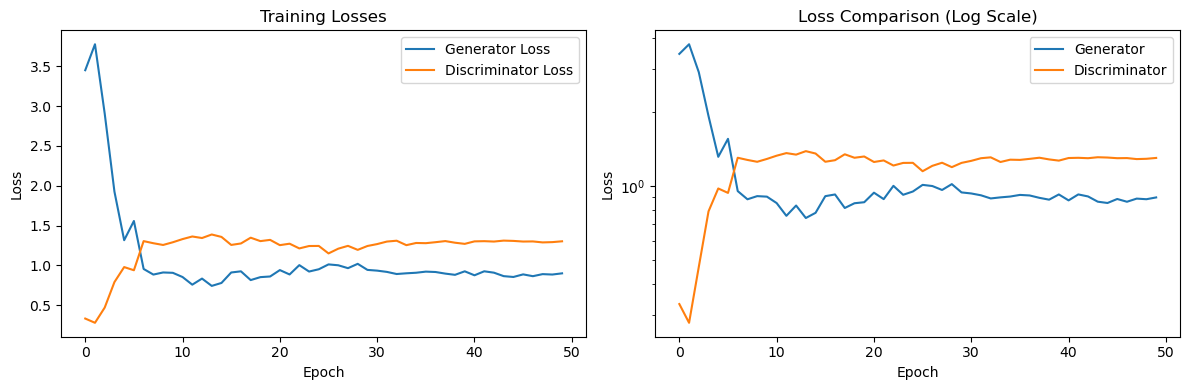

In [11]:
### YOUR CODE HERE - Exercise 1 ###
def plot_losses(gen_losses, disc_losses):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(gen_losses, label='Generator')
    plt.plot(disc_losses, label='Discriminator')
    plt.title('Loss Comparison (Log Scale)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

# Plot the losses
plot_losses(gen_losses, disc_losses)


## Exercise 2: Generate Image Grid

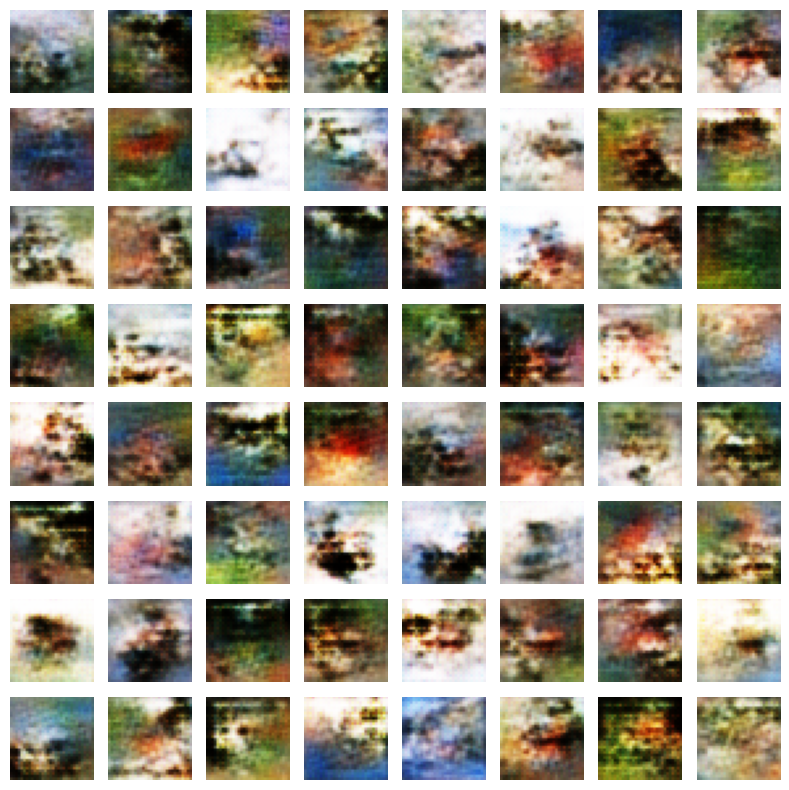

In [12]:
### YOUR CODE HERE - Exercise 2 ###
def generate_image_grid(generator, grid_size=8):
    noise = tf.random.normal([grid_size * grid_size, latent_dim])
    generated_images = generator(noise, training=False)
    
    fig = plt.figure(figsize=(grid_size, grid_size))
    
    for i in range(generated_images.shape[0]):
        plt.subplot(grid_size, grid_size, i+1)
        # Denormalize images from [-1, 1] to [0, 1]
        image = (generated_images[i] + 1) / 2.0
        plt.imshow(image)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

grid_size = 8  # For 8x8 grid of images
generate_image_grid(generator, grid_size)

## Exercise 3: Compare Real vs Generated Images

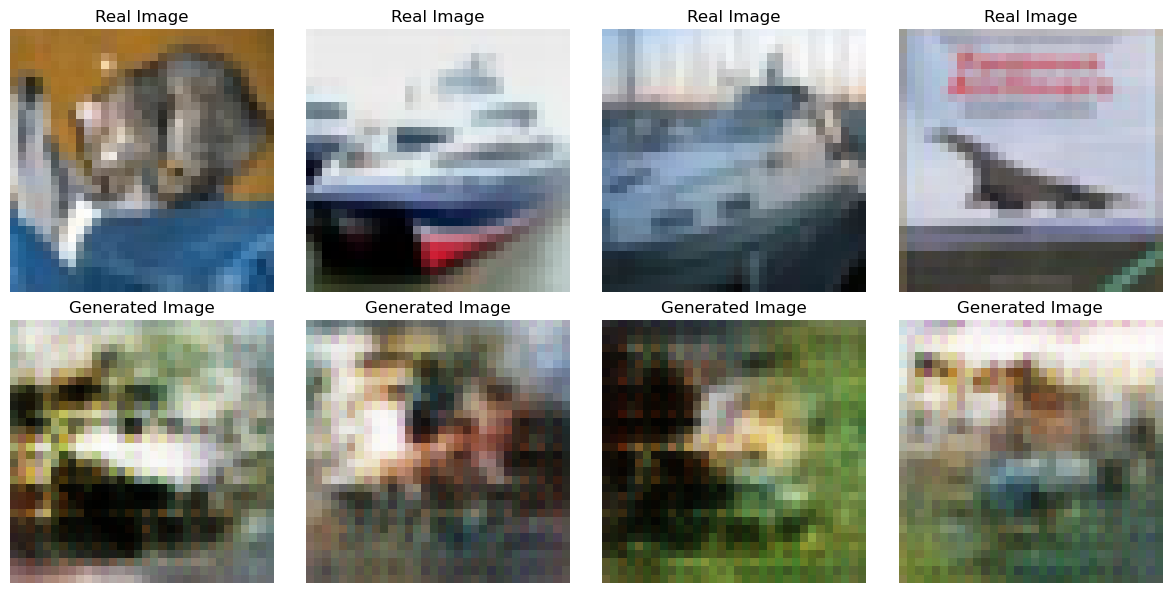

In [13]:
### YOUR CODE HERE - Exercise 3 ###
def compare_real_vs_generated(generator, real_images, n_images=4):
    # Generate fake images
    noise = tf.random.normal([n_images, latent_dim])
    generated_images = generator(noise, training=False)
    
    fig, axes = plt.subplots(2, n_images, figsize=(n_images*3, 6))
    
    for i in range(n_images):
        # Real images
        axes[0, i].imshow((real_images[i] + 1) / 2.0)
        axes[0, i].set_title('Real Image')
        axes[0, i].axis('off')
        
        # Generated images
        axes[1, i].imshow((generated_images[i] + 1) / 2.0)
        axes[1, i].set_title('Generated Image')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

n_images = 4  # Number of images to compare
compare_real_vs_generated(generator, x_test[:n_images], n_images)


## Exercise 4: Latent Space Interpolation

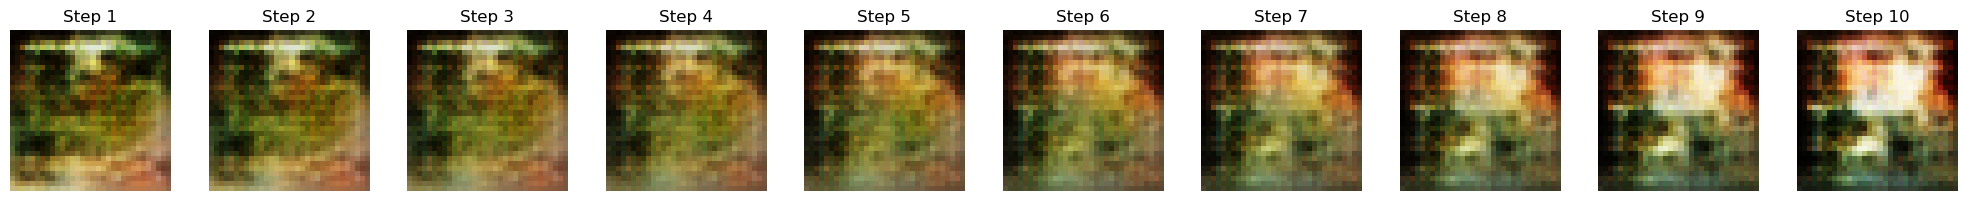

In [14]:
### YOUR CODE HERE - Exercise 4 ###
def interpolate_latent_space(generator, steps=10):
    # Generate two random latent vectors
    z1 = tf.random.normal([1, latent_dim])
    z2 = tf.random.normal([1, latent_dim])
    
    # Create interpolation steps
    interpolated_vectors = []
    for i in range(steps):
        alpha = i / (steps - 1)
        interpolated_z = (1 - alpha) * z1 + alpha * z2
        interpolated_vectors.append(interpolated_z)
    
    interpolated_vectors = tf.concat(interpolated_vectors, axis=0)
    interpolated_images = generator(interpolated_vectors, training=False)
    
    # Plot interpolation
    fig, axes = plt.subplots(1, steps, figsize=(steps*2, 2))
    for i in range(steps):
        axes[i].imshow((interpolated_images[i] + 1) / 2.0)
        axes[i].axis('off')
        axes[i].set_title(f'Step {i+1}')
    
    plt.tight_layout()
    plt.show()

# Perform interpolation
interpolate_latent_space(generator, steps=10)


## Bonus Exercise: Model Summaries

In [15]:
### YOUR CODE HERE - Bonus ###
# Display the architecture of your models
# Use generator.summary() and discriminator.summary()
# Analyze the number of parameters in each model

print("Generator Model Summary:")
print("=" * 50)
generator.summary()

print("\nDiscriminator Model Summary:")
print("=" * 50)
discriminator.summary()

# Analyze parameters
gen_params = generator.count_params()
disc_params = discriminator.count_params()
total_params = gen_params + disc_params

print(f"\nModel Parameter Analysis:")
print(f"Generator parameters: {gen_params:,}")
print(f"Discriminator parameters: {disc_params:,}")
print(f"Total parameters: {total_params:,}")
print(f"Generator/Total ratio: {gen_params/total_params:.2%}")
print(f"Discriminator/Total ratio: {disc_params/total_params:.2%}")

Generator Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16384)          │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 3)      │         9,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,533,248 (9.66 MB)

 Trainable params: 2,500,224 (9.54 MB)

 Non-trainable params: 33,024 (129.00 KB)


Discriminator Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,985 (851.50 KB)

 Trainable params: 217,985 (851.50 KB)

 Non-trainable params: 0 (0.00 B)


Model Parameter Analysis:
Generator parameters: 2,533,248
Discriminator parameters: 217,985
Total parameters: 2,751,233
Generator/Total ratio: 92.08%
Discriminator/Total ratio: 7.92%
